In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

/home/grin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
dataset = pd.read_csv('NYC_Jobs.csv')
dataset.head(1)

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Salary Range From,Salary Range To,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,132719,DEPT OF ENVIRONMENT PROTECTION,External,2,Stationary Engineer (Electric),STATIONARY ENGINEER (ELECTRIC),91645,00,94983,94983,...,Appointments are subject to OMB approval For ...,Click the ''Apply Now'' button,,"3701 Jerome Ave, Bx NY 10467",NaN,New York City residency is generally required ...,10/08/2013 00:00:00,NaN,10/08/2013 00:00:00,10/27/2015 00:00:00


In [4]:
print dataset.columns

Index([u'Job ID', u'Agency', u'Posting Type', u'# Of Positions',
       u'Business Title', u'Civil Service Title', u'Title Code No', u'Level',
       u'Salary Range From', u'Salary Range To', u'Salary Frequency',
       u'Work Location', u'Division/Work Unit', u'Job Description',
       u'Minimum Qual Requirements', u'Preferred Skills',
       u'Additional Information', u'To Apply', u'Hours/Shift',
       u'Work Location 1', u'Recruitment Contact', u'Residency Requirement',
       u'Posting Date', u'Post Until', u'Posting Updated', u'Process Date'],
      dtype='object')


Посчитаем распределение вакансий по разным способам оплаты (за год, за месяц, за час). Вакансии из разных групп придётся исследовать отдельно, так как не понятно, сколько часов и сколько дней люди работают. Сложно оценить размер годовой зарплаты, если по данной вакансии почасовая оплата.

In [5]:
grouped_frequency = dataset.groupby('Salary Frequency')
grouped_frequency.count()['Job ID']

Salary Frequency
Annual    3146
Daily       28
Hourly     255
Name: Job ID, dtype: int64

Посмотрим, какие есть разные значения в столбце 'Agency', и сколько их всего:

In [6]:
grouped_agency = dataset.groupby('Agency')
grouped_agency_count = grouped_agency.size().sort_values(ascending=False)
print grouped_agency_count
print "Total number of agencies: " + str(len(grouped_agency.groups.keys()))

Agency
DEPT OF HEALTH/MENTAL HYGIENE     863
DEPT OF ENVIRONMENT PROTECTION    424
DEPT OF DESIGN & CONSTRUCTION     264
DEPT OF INFO TECH & TELECOMM      236
ADMIN FOR CHILDREN'S SVCS         180
DEPARTMENT OF BUILDINGS           170
DEPARTMENT OF CORRECTION          161
HOUSING PRESERVATION & DVLPMNT    153
DEPARTMENT OF TRANSPORTATION      112
DEPARTMENT OF FINANCE              87
FIRE DEPARTMENT                    77
DEPARTMENT OF INVESTIGATION        64
HRA/DEPT OF SOCIAL SERVICES        61
DEPARTMENT OF BUSINESS SERV.       60
CONSUMER AFFAIRS                   58
NYC HOUSING AUTHORITY              58
DEPT OF PARKS & RECREATION         50
DEPT OF CITYWIDE ADMIN SVCS        38
DEPT. OF HOMELESS SERVICES         35
ADMIN TRIALS AND HEARINGS          32
LAW DEPARTMENT                     28
FINANCIAL INFO SVCS AGENCY         26
CIVILIAN COMPLAINT REVIEW BD       24
DEPT OF YOUTH & COMM DEV SRVS      23
TAXI & LIMOUSINE COMMISSION        22
DEPARTMENT OF SANITATION           18
NYC E

/home/grin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


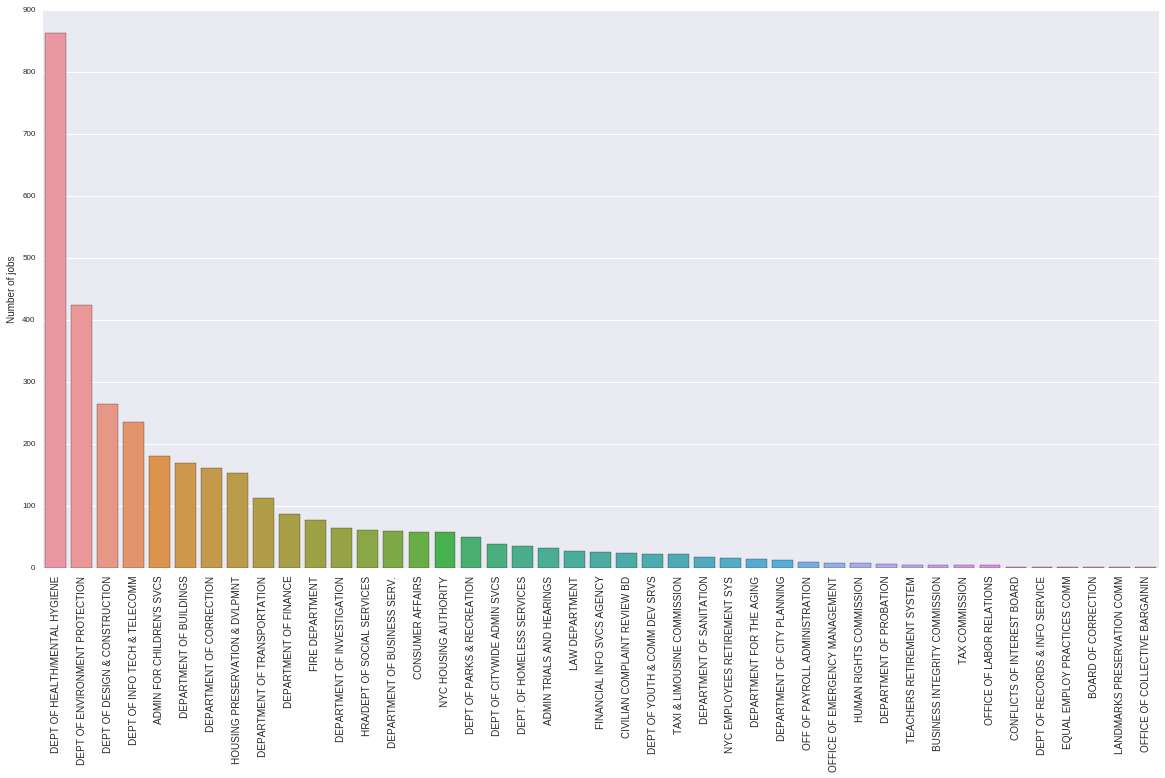

In [7]:
def plot_bar_counts(data, ylabel):
    fig = plt.figure(figsize=(20,10))
    plt.yticks(fontsize=8)
    plt.xticks(rotation=90)
    sns.barplot(x=data.keys().values,y=data.values)
    plt.xlabel('')
    plt.ylabel(ylabel,fontsize=10)
    
plot_bar_counts(grouped_agency_count, 'Number of jobs')

Добавим в таблицу столец AvgSalary, обозначающий среднюю зарплату.

In [8]:
dataset['AvgSalary'] = (dataset['Salary Range From'] + dataset['Salary Range To']) / 2

Построим распределение средней зарплаты для тех вакансий, в которых указан годовой доход, в зависимости от Agency в порядке убывания среднего значения зарплаты.

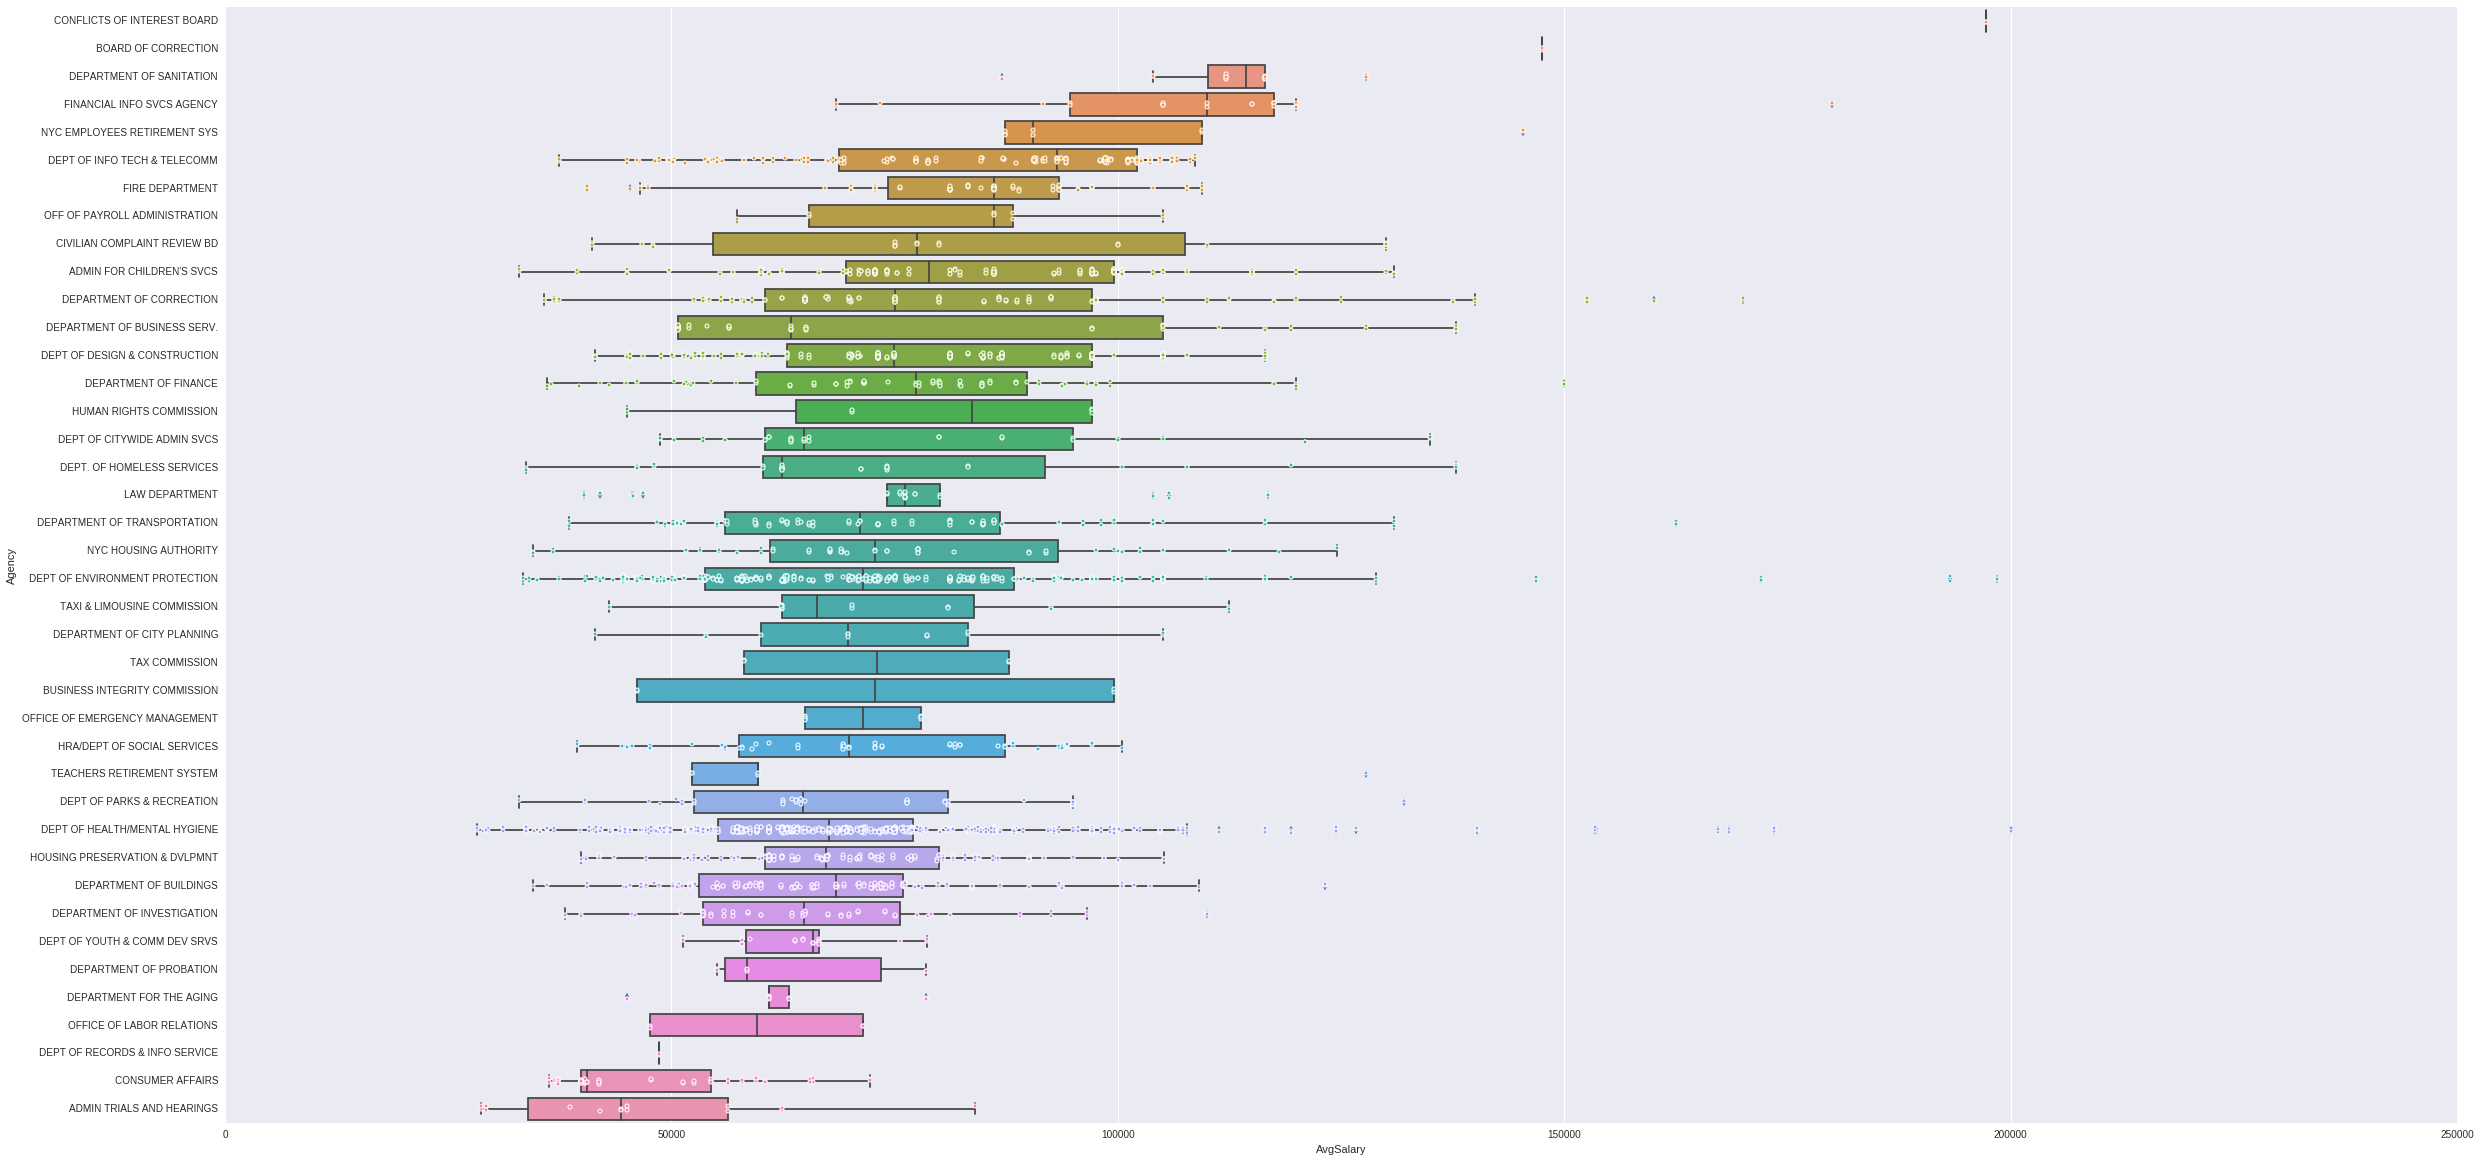

In [9]:
def violin_plot_cat(data, cat, val):
    data_grouped = data.groupby(cat)
    means = data_grouped[val].mean()
    order = means.sort_values(ascending=False).keys().values
    fig = plt.figure(figsize=(40,20))
    sns.boxplot(x=val, y=cat, data=data, order=order)
    sns.stripplot(x=val, y=cat, data=data, jitter=True, size=4, order=order);
    
dataset_annual = dataset[dataset['Salary Frequency']=="Annual"]
violin_plot_cat(dataset_annual,'Agency','AvgSalary')

Построим гистограмму распределения средней зарплаты по всем вакансиям, где указан годовой доход.

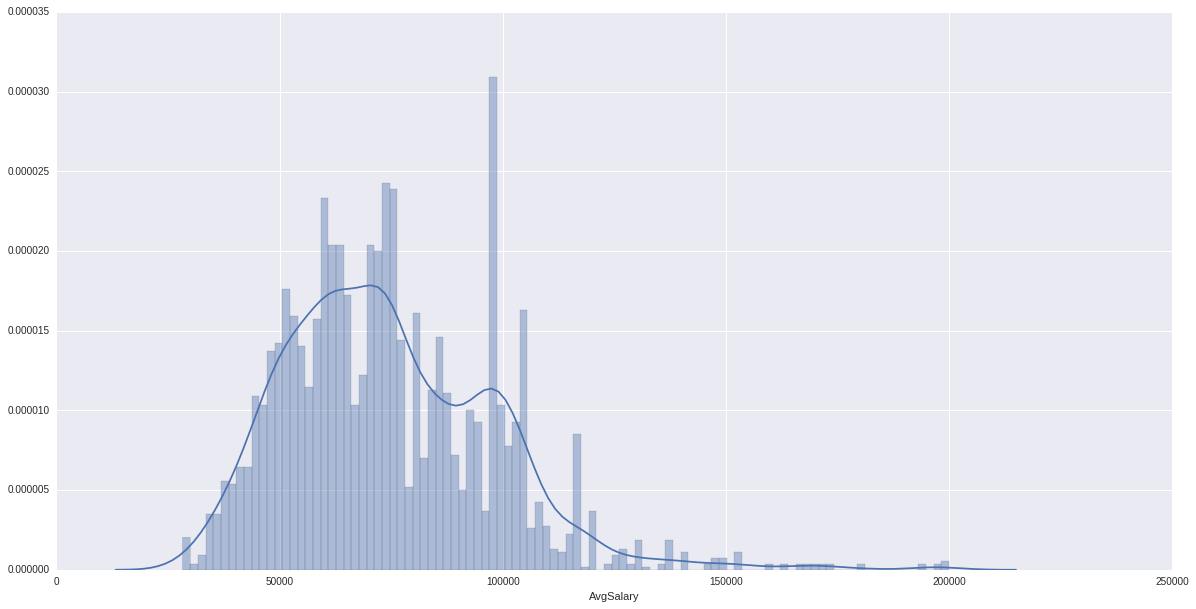

In [10]:
def plot_hist(data, n_bins):
    fig = plt.figure(figsize=(20,10))
    sns.distplot(data, bins=n_bins)
    
plot_hist(dataset_annual['AvgSalary'], 100)

Для того, чтобы найти координаты мест работы, воспользуемся Google Geocoding API: https://developers.google.com/maps/documentation/geocoding/intro
Для этого нужно иметь ключ (GOOGLE_API_KEY). Чтобы не тратить свою квоту, я скачал все 1 раз, сохранил получившуюся структуру с помощью pickle.

In [11]:
import requests
GOOGLE_API_KEY = "<your-api-key>"
GOOGLE_API_URL = 'https://maps.googleapis.com/maps/api/geocode/json?address="{0}"&key={1}'

def fetch_location(location):
    full_url = GOOGLE_API_URL.format(location, GOOGLE_API_KEY);
    answer = requests.get(full_url).json()
    results = answer['results']
    if len(results) > 0:
        position = results[0]['geometry']['location']
        return [position['lat'], position['lng']]
    else:
        return None
    
def get_all_locations(data):
    res = dict()
    all_locations = data.groupby('Work Location').groups.keys()
    for idx, location in enumerate(all_locations):
        print "{0} out of {1}".format(idx, len(all_locations))
        pos = fetch_location(location)
        res[location] = pos

    return res

In [12]:
LOAD_FROM_FILE = True

In [13]:
import pickle
if LOAD_FROM_FILE:
    f = open('locations2.data', 'rb')
    locations = pickle.load(f)
    f.close()
else:
    locations = get_all_locations(dataset)

In [21]:
import folium
import random
from matplotlib import cm

NEW_YORK_COORDINATES = (40.7127, -74.0059)
RANDOM_VEC_SCALE = 0.0002

def shift_vec(vec):
    v = np.random.random(2) * RANDOM_VEC_SCALE + np.array(vec)
    return v.tolist()

def rgb_to_hex(color):

def plot_vacancies_on_map(map_in, data, locations):
    max_salary = data['AvgSalary'].max()
    for i in range(0, data.shape[0]):
        location = data['Work Location'][i]
        pos = locations[location]
        salary = data['AvgSalary'][i]
        label = data['Job Description'][i]
        if pos is not None:
            color = cm.rainbow(salary / max_salary)
            color_str = "#%02X%02X%02X" % (color[0], color[1], color[2])
            map_in.circle_marker(location=shift_vec(pos), popup=str(pos), fill_color=color_str, radius=1, fill_opacity=1, line_color=color_str)
        
def plot_locations_on_map(map_in, locations):
    for val in locations.itervalues():
        if val is not None:
            map_in.circle_marker(location=val, popup='Hello!', fill_color='green', radius=10)
        
map_osm = folium.Map(location=NEW_YORK_COORDINATES)
plot_vacancies_on_map(map_osm, dataset, locations)
map_osm

In [15]:
print generate_random_vec()
print generate_random_vec()
print generate_random_vec()
print generate_random_vec()
print generate_random_vec()

NameError: name 'generate_random_vec' is not defined

In [ ]:
[1,2]+[3,4]